# LGS5145 DCDC Characterize

In [1]:
import pyvisa
import time

In [8]:
# Find instrument and connect
rm = pyvisa.ResourceManager()
inst_list = rm.list_resources()
inst = rm.open_resource(inst_list[0], baud_rate=115200) # RS232 connection
inst.timeout = 5000
inst.write("*RST; *CLS")    # reset to power on state, clear status
print(inst.query("*IDN?"))  # get instrument id

HEWLETT-PACKARD,34970A,0,13-2-2



In [11]:
# configure channels
inst.write("configure:voltage:dc 100,DEF,(@101)")   # input voltage, channel 1, 100V range
inst.write("configure:voltage:dc 10,DEF,(@102)")    # output voltage, channel 2, 10V range
inst.write("configure:current:dc 1,DEF,(@121)")     # input current, channel 21, 1A range
inst.write("configure:current:dc 1,DEF,(@122)")     # output current, channel 22, 1A range
time.sleep(0.1)
inst.write("configure:temperature TC,K,(@103)")     # k type TC

35

In [12]:
# get channel configurations
print(inst.query("configure? (@101)"))
print(inst.query("configure? (@102)"))
print(inst.query("configure? (@121)"))
print(inst.query("configure? (@122)"))
print(inst.query("configure? (@103)"))

"VOLT +1.000000E+02,+3.000000E-04"

"VOLT +1.000000E+01,+3.000000E-05"

"CURR +1.000000E+00,+3.000000E-06"

"CURR +1.000000E+00,+3.000000E-06"

"TEMP TC,K,+1.000000E+00,+3.000000E-06"



In [20]:
# configure scanning

''' settings '''
scanIntervals = 10      # Delay in secs, between scans
numberScans = 1         # Number of scan sweeps to measure
channelDelay = 0.1      # Delay, in secs, between relay closure and measurement
scanlist = "(@101:102,103,121:122)"

# setup scan list
inst.write("ROUTE:SCAN " + scanlist)
numberChannels = int(inst.query("ROUTE:SCAN:SIZE?"))
print("number of channels: {}".format(numberChannels))

# reading format
# inst.write("FORMAT:READING:CHAN OFF") # dont return channel number
# inst.write("FORMAT:READING:TIME OFF") # dont return time

# channel delay
# inst.write("ROUT:CHAN:DELAY " + str(channelDelay)+ "," + scanlist)

# setup when scanning starts and interval rate
inst.write("TRIG:COUNT " + str(numberScans)) 
inst.write("TRIG:SOUR TIMER")
inst.write("TRIG:TIMER " + str(scanIntervals))

#start the scan
# inst.write("INIT")  # start scan

number of channels: 5


15

In [29]:
print(inst.query("DATA:POINTS?"))

+0



In [31]:
# Collect data
print("Vin, Vout, TC, Iin, Iout")

for v in range(0, 700):
    inst.write("source:voltage {},(@204)".format(v/100))   # set DAC to voltage
    time.sleep(1) # sleep for 10 seconds
    inst.write("INIT")  # start scan
    time.sleep(1)   # wait for scan

    # read data
    vin_str = inst.query("DATA:REMOVE? 1")
    vout_str = inst.query("DATA:REMOVE? 1")
    tc_str = inst.query("DATA:REMOVE? 1")
    iin_str = inst.query("DATA:REMOVE? 1")
    iout_str = inst.query("DATA:REMOVE? 1")

    vin_str = vin_str.replace('\r\n', '')
    vout_str = vout_str.replace('\r\n', '')
    tc_str = tc_str.replace('\r\n', '')
    iin_str = iin_str.replace('\r\n', '')
    iout_str = iout_str.replace('\r\n', '')

    # print data
    print("{}, {}, {}, {}, {}".format(vin_str, vout_str, tc_str, iin_str, iout_str))

# turn off current
inst.write("source:voltage 0,(@204)")   # set DAC to voltage


Vin, Vout, TC, Iin, Iout
+4.50579690E+01, +5.02023500E+00, +2.22950000E+01, +1.32200000E-04, +3.93000000E-06
+4.50596650E+01, +5.04530680E+00, +2.23310000E+01, +1.34820000E-04, +2.62000000E-06
+4.50566630E+01, +5.01254380E+00, +2.23150000E+01, +1.66230000E-04, +2.61780000E-04
+4.50570550E+01, +5.01276580E+00, +2.23700000E+01, +3.16760000E-04, +1.28798000E-03
+4.50594040E+01, +5.01258290E+00, +2.24410000E+01, +4.62050000E-04, +2.31287000E-03
+4.50548360E+01, +5.01191700E+00, +2.24760000E+01, +6.03410000E-04, +3.31682000E-03
+4.50560110E+01, +5.01126410E+00, +2.25830000E+01, +7.51320000E-04, +4.36657000E-03
+4.50607100E+01, +5.01098980E+00, +2.26670000E+01, +8.96610000E-04, +5.37837000E-03
+4.50601870E+01, +5.01080700E+00, +2.27480000E+01, +1.04060000E-03, +6.41504000E-03
+4.50577080E+01, +5.01046750E+00, +2.28250000E+01, +1.18327000E-03, +7.40066000E-03
+4.50590130E+01, +5.00987990E+00, +2.29090000E+01, +1.31547000E-03, +8.44649000E-03
+4.50595350E+01, +5.00961870E+00, +2.30000000E+01, 

25

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

In [39]:
df = pd.read_csv("lgs5145_40Vin_withTC_longDelay.csv")
df.head()

,Vin,Vout,TC,Iin,Iout
0,40.027844,4.996208,22.164,0.000153,0.000005
1,40.033587,5.006028,22.949,0.001462,0.008534
2,40.038155,5.002580,24.005,0.003056,0.018800
3,40.039460,4.999838,24.940,0.004662,0.029080
4,40.042071,4.997527,26.148,0.006251,0.039321


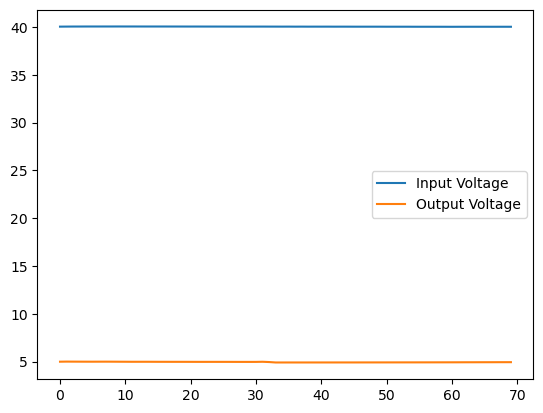

In [40]:
plt.plot(df['Vin'], label = "Input Voltage")
plt.plot(df[' Vout'], label = "Output Voltage")
plt.legend()
plt.show()

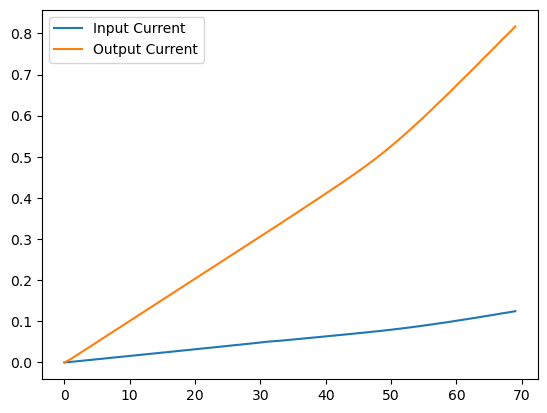

In [41]:
plt.plot(df[" Iin"], label = "Input Current")
plt.plot(df[' Iout'], label = "Output Current")
plt.legend()
plt.show()

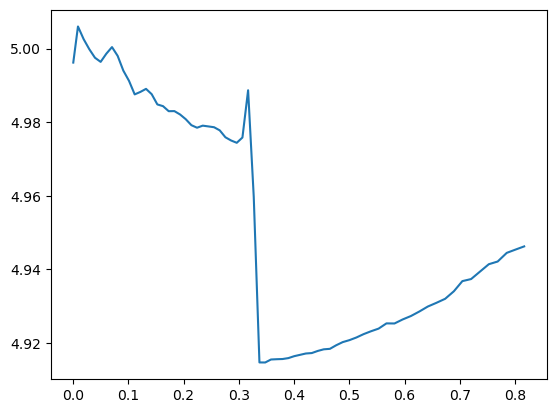

In [42]:
plt.plot(df[' Iout'], df[' Vout'])
plt.show()

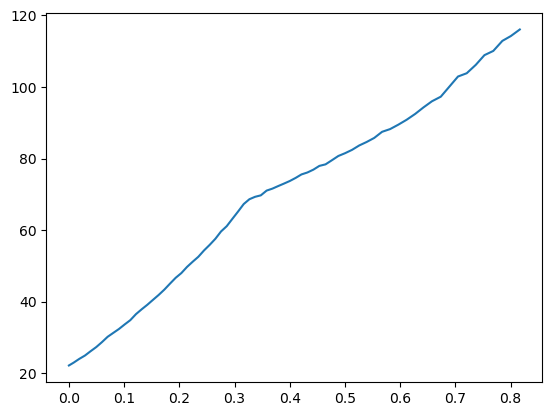

In [43]:
plt.plot(df[' Iout'], df[' TC'])
plt.show()

# Thermal Stability

In [38]:
# Collect data
print("Vin, Vout, TC, Iin, Iout")

for v in range(0, 70):
    inst.write("source:voltage {},(@204)".format(v/10))   # set DAC to voltage
    time.sleep(10*60) # wait 10 minutes for stability
    inst.write("INIT")  # start scan
    time.sleep(1)   # wait for scan

    # read data
    vin_str = inst.query("DATA:REMOVE? 1")
    vout_str = inst.query("DATA:REMOVE? 1")
    tc_str = inst.query("DATA:REMOVE? 1")
    iin_str = inst.query("DATA:REMOVE? 1")
    iout_str = inst.query("DATA:REMOVE? 1")

    vin_str = vin_str.replace('\r\n', '')
    vout_str = vout_str.replace('\r\n', '')
    tc_str = tc_str.replace('\r\n', '')
    iin_str = iin_str.replace('\r\n', '')
    iout_str = iout_str.replace('\r\n', '')

    # print data
    print("{}, {}, {}, {}, {}".format(vin_str, vout_str, tc_str, iin_str, iout_str))

# turn off current
inst.write("source:voltage 0,(@204)")   # set DAC to voltage

Vin, Vout, TC, Iin, Iout
+4.00278440E+01, +4.99620800E+00, +2.21640000E+01, +1.53140000E-04, +5.24000000E-06
+4.00335870E+01, +5.00602780E+00, +2.29490000E+01, +1.46207000E-03, +8.53419000E-03
+4.00381550E+01, +5.00258040E+00, +2.40050000E+01, +3.05634000E-03, +1.88000900E-02
+4.00394600E+01, +4.99983820E+00, +2.49400000E+01, +4.66239000E-03, +2.90804000E-02
+4.00420710E+01, +4.99752690E+00, +2.61480000E+01, +6.25143000E-03, +3.93214300E-02
+4.00425930E+01, +4.99640390E+00, +2.73110000E+01, +7.86533000E-03, +4.95978200E-02
+4.00427230E+01, +4.99862380E+00, +2.86880000E+01, +9.47662000E-03, +5.98807400E-02
+4.00435070E+01, +5.00042580E+00, +3.01750000E+01, +1.11153900E-02, +7.01584400E-02
+4.00433760E+01, +4.99803620E+00, +3.12710000E+01, +1.27240600E-02, +8.04007800E-02
+4.00452030E+01, +4.99402730E+00, +3.23600000E+01, +1.43170200E-02, +9.06798000E-02
+4.00433760E+01, +4.99124590E+00, +3.36260000E+01, +1.59283100E-02, +1.00967950E-01
+4.00440290E+01, +4.98756360E+00, +3.48290000E+01, 

25